In [50]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import PIL
from PIL import Image
from PIL import ImageFilter
import scipy.misc as misc
import random
import pandas as pd
import tensorflow as tf
import h5py
import math

### Loading Data:

In [3]:
#loading data
# test_bbox = pickle.load( open( "test_bbox.pickle", "rb" ) )

# train_bbox = pickle.load( open( "train_bbox.pickle", "rb" ) )
train_data = pickle.load( open( "train_data_part4.pickle", "rb" ) )
test_data = pickle.load( open( "test_data_part4.pickle", "rb" ) )

Testing fidelity of data and bounding box correctness.  AND removing any numbers greater than 5 digits.  There is one with 6.


data is in format [[image arr, label, bb]....]

bbox is in this order [ y_top, y_bot, x_left, x_right]

/Users/jdschonhoft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  from ipykernel import kernelapp as app
/Users/jdschonhoft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  app.launch_new_instance()


bounding box:  [2.3703703703703702, 59.25925925925926, 17.723076923076924, 45.784615384615385]
image number:  38


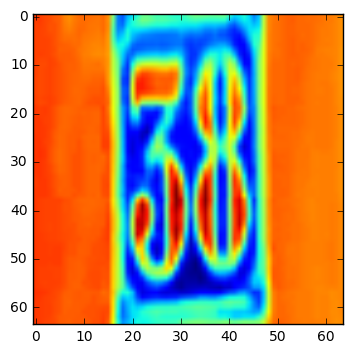

/Users/jdschonhoft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


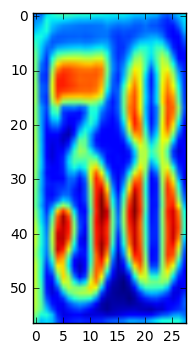

In [4]:
#remove images with 'nodata' from cleaning step
train_ = filter(lambda x: x[0] != 'nodata', train_data)
test_ = filter(lambda x: x[0] != 'nodata', test_data)

#removing data if digit greater than 5
train_ = filter(lambda x: len(x[1]) < 6, train_)
test_ = filter(lambda x: len(x[1]) < 6, test_)

#now testing fidelity of data
imgnumber = 861
bb = train_data[imgnumber][2]
print('bounding box: ', train_data[imgnumber][2])
print('image number: ', train_data[imgnumber][1])
plt.imshow(train_data[imgnumber][0])
plt.show()
plt.imshow(train_data[imgnumber][0][bb[0]:bb[1], bb[2] : bb[3]])
plt.show()

5


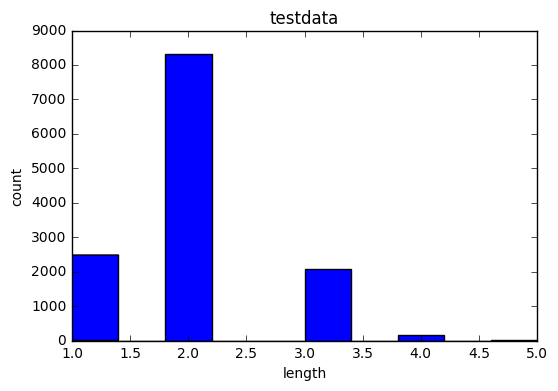

5


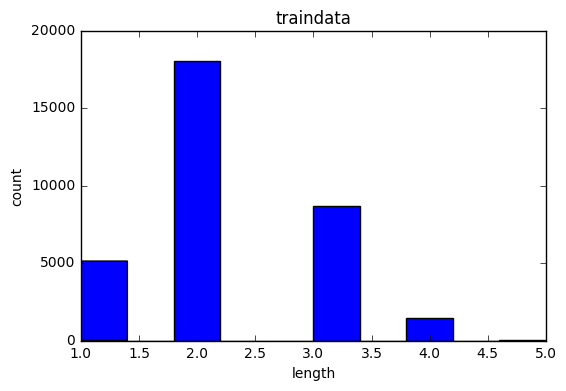

In [5]:
# looking at distribution of train and test data
labels = zip(*test_)[1]
labels = [len(i) for i in labels]
print(max(labels))
plt.hist(labels)
plt.xlabel('length')
plt.ylabel('count')
plt.title('testdata')
plt.show()

labels = zip(*train_)[1]
labels = [len(i) for i in labels]
print(max(labels))
plt.hist(labels)
plt.xlabel('length')
plt.ylabel('count')
plt.title('traindata')
plt.show()

### formating data

### reformatting data for tensorflow.  Note that the images are still being fed into tensor flow without any cropping.

In [7]:
image_size = 64
# num_labels = 11  #0-9 + blank
num_channels = 1 # grayscale

#formating data
train_dataset = np.array(zip(*train_)[0]).astype(dtype=np.float32)
train_labels = np.array([[len(i)] + [int(k) for k in i] + [int(10)]*(5-len(i)) for i in zip(*train_)[1]])
train_bb = np.array([i for i in zip(*train_)[2]]).astype(dtype=np.float32) 

valid_dataset = np.array(zip(*train_)[0]).astype(dtype=np.float32)
valid_labels = np.array([[len(i)] + [int(k) for k in i] + [int(10)]*(5-len(i)) for i in zip(*train_)[1]])
valid_bb = np.array([i for i in zip(*train_)[2]]).astype(dtype=np.float32) 

test_dataset = np.array(zip(*test_)[0]).astype(dtype=np.float32)
test_labels = np.array([[len(i)] + [int(k) for k in i] + [int(10)]*(5-len(i)) for i in zip(*test_)[1]])
test_bb = np.array([i for i in zip(*test_)[2]]).astype(dtype=np.float32)

def reformat(dataset, labels, bbox):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    return dataset, labels, bbox
train_dataset, train_labels, train_bbox = reformat(train_dataset, train_labels, train_bb)
valid_dataset, valid_labels, valid_bbox = reformat(valid_dataset, valid_labels, valid_bb)
test_dataset, test_labels, test_bbox = reformat(test_dataset, test_labels, valid_bb)

print('Training set', train_dataset.shape, train_labels.shape, train_bbox.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape, valid_bbox.shape)
print('Test set', test_dataset.shape, test_labels.shape, test_bbox.shape)

Training set (33234, 64, 64, 1) (33234, 6) (33234, 4)
Validation set (33234, 64, 64, 1) (33234, 6) (33234, 4)
Test set (13027, 64, 64, 1) (13027, 6) (33234, 4)


### Now training a regression model for the bbox corners

In [8]:

#parameters
batch_size = 20
image_size = 64
patch_size = 3

d1 = 4
d2 = 8
d3 = 16
d4 = 32
d5 = 64
d6 = 128
d7 = 256
d8 = 512
sdev = math.sqrt(2.0 / (32**2*1))


#tensorflow computational graph
graph = tf.Graph()
with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size, image_size, 1))
    tf_train_bbox = tf.placeholder(tf.float32, shape=(batch_size,4))
    tf_eval = tf.placeholder(tf.float32,shape=(batch_size, image_size, image_size, 1))

    
    # Variables.
    conv1_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, 1, d1], stddev=sdev))
    conv1_b = tf.Variable(tf.zeros([d1]))
    
    conv2_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d1, d2], stddev=sdev))
    conv2_b = tf.Variable(tf.zeros([d2]))
    
    conv3_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d2, d3], stddev=sdev))
    conv3_b = tf.Variable(tf.zeros([d3]))
    
    conv4_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d3, d4], stddev=sdev))
    conv4_b = tf.Variable(tf.zeros([d4]))
    
    conv5_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d4, d5], stddev=sdev))
    conv5_b = tf.Variable(tf.zeros([d5]))
    
    conv6_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d5, d6], stddev=sdev))
    conv6_b = tf.Variable(tf.zeros([d6]))
    
    conv7_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d6, d7], stddev=sdev))
    conv7_b = tf.Variable(tf.zeros([d7]))
    
    conv8_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d7, d8], stddev=sdev))
    conv8_b = tf.Variable(tf.zeros([d8]))
    
    fc1_w = tf.Variable(tf.truncated_normal([128,512], stddev=0.1))
    fc1_b = tf.Variable(tf.constant(1.0, shape=[64]))

    #for final logits
    hidden2 = 512
    b1_w = tf.get_variable('b1_w', shape=[hidden2, 1],initializer=tf.contrib.layers.xavier_initializer())
    b1_b = tf.Variable(tf.constant(1.0, shape=[1]))
    b2_w = tf.get_variable('b2_w',shape=[hidden2, 1],initializer=tf.contrib.layers.xavier_initializer())
    b2_b = tf.Variable(tf.constant(1.0, shape=[1]))
    b3_w = tf.get_variable('b3_w',shape=[hidden2, 1],initializer=tf.contrib.layers.xavier_initializer())
    b3_b = tf.Variable(tf.constant(1.0, shape=[1]))
    b4_w = tf.get_variable('b4_w',shape=[hidden2, 1],initializer=tf.contrib.layers.xavier_initializer())
    b4_b = tf.Variable(tf.constant(1.0, shape=[1]))

    # Model.
    def model(data):
        '''
        Our best architecture consists of eight convolutional hidden layers
        one locally connected hidden layer, and two densely connected hidden layers.
        All connections are feedforward and go from one layer to the next (no skip connections).
        The first hidden layer contains maxout units (Goodfellow et al., 2013) (with three filters per unit)
        while the others contain rectifier units (Jarrett et al., 2009; Glorot et al., 2011). 
        The number of units at each spatial location in each layer is [48, 64, 128, 160] 
        for the first four layers and 192 for all other locally connected layers. 
        The fully connected layers contain 3,072 units each. 
        Each convolutional layer includes max pooling and subtractive normalization. 
        The max pooling window size is 2 × 2. 
        The stride alternates between 2 and 1 at each layer, 
        so that half of the layers don’t reduce the spatial size of the representation. 
        All convolutions use zero padding on the input to preserve representation size. 
        The subtractive normalization operates on 3x3 windows and preserves representation size. 
        All convolution kernels were of size 5 × 5. 
        We trained with dropout applied to all hidden layers but not the input.
        '''
        pad  = 'SAME'
        conv1 = tf.nn.conv2d(data, conv1_w, [1, 1, 1, 1], padding=pad)
        conv1 = tf.nn.relu(conv1 + conv1_b)
        conv1 = tf.nn.max_pool(conv1, [1,2,2,1], [1,2,2,1], padding=pad)
#         print(conv1.get_shape())
        conv2 = tf.nn.conv2d(conv1, conv2_w, [1, 1, 1, 1], padding=pad)
        conv2 = tf.nn.relu(conv2 + conv2_b)
        conv2 = tf.nn.max_pool(conv2, [1,2,2,1], [1,2,2,1], padding=pad)
#         print(conv2.get_shape())
        conv3 = tf.nn.conv2d(conv2, conv3_w, [1, 1, 1, 1], padding=pad)
        conv3 = tf.nn.relu(conv3 + conv3_b)
        conv3 = tf.nn.max_pool(conv3, [1,2,2,1], [1,2,2,1], padding=pad)
#         print(conv3.get_shape())
        conv4 = tf.nn.conv2d(conv3, conv4_w, [1, 1, 1, 1], padding=pad)
        conv4 = tf.nn.relu(conv4 + conv4_b)
        conv4 = tf.nn.max_pool(conv4, [1,2,2,1], [1,2,2,1], padding=pad)
#         print(conv4.get_shape())
        conv5 = tf.nn.conv2d(conv4, conv5_w, [1, 1, 1, 1], padding=pad)
        conv5 = tf.nn.relu(conv5 + conv5_b)
        conv5 = tf.nn.max_pool(conv5, [1,2,2,1], [1,2,2,1], padding=pad)
#         print(conv5.get_shape())
        conv6 = tf.nn.conv2d(conv5, conv6_w, [1, 1, 1, 1], padding=pad)
        conv6 = tf.nn.relu(conv6 + conv6_b)
        conv6 = tf.nn.max_pool(conv6, [1,2,2,1], [1,2,2,1], padding=pad)
#         print(conv6.get_shape())
        conv7 = tf.nn.conv2d(conv6, conv7_w, [1, 1, 1, 1], padding=pad)
        conv7 = tf.nn.relu(conv7 + conv7_b)
        conv7 = tf.nn.max_pool(conv7, [1,2,2,1], [1,2,2,1], padding=pad)
#         print(conv7.get_shape())
        conv8 = tf.nn.conv2d(conv7, conv8_w, [1, 1, 1, 1], padding=pad)
        conv8 = tf.nn.relu(conv8 + conv8_b)
        conv8 = tf.nn.max_pool(conv8, [1,2,2,1], [1,2,2,1], padding=pad)
#         print(conv8.get_shape())
    
        #bounding box
        shape_bb = conv8.get_shape().as_list()
        reshape_bb = tf.reshape(conv8, [shape_bb[0], shape_bb[1] * shape_bb[2] * shape_bb[3]])  
        fc1_bb = tf.nn.dropout(reshape_bb, keep_prob = 0.8)
        
        #four classifiers for the bounding box, locating the number in the image
        b1 = tf.matmul(fc1_bb, b1_w) + b1_b
        b2 = tf.matmul(fc1_bb, b2_w) + b2_b
        b3 = tf.matmul(fc1_bb, b3_w) + b3_b
        b4 = tf.matmul(fc1_bb, b4_w) + b4_b
        
        return [b1, b2, b3, b4]

    # Training computation. #no length logit
    [b1, b2, b3, b4] = model(tf_train_dataset)
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()

    #regression loss
    loss = tf.reduce_mean(tf.square(b1-tf_train_bbox[:,0])) +\
    tf.reduce_mean(tf.square(b2-tf_train_bbox[:,1])) +\
    tf.reduce_mean(tf.square(b3-tf_train_bbox[:,2])) +\
    tf.reduce_mean(tf.square(b4-tf_train_bbox[:,3]))
    
    # Optimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss) 
    
    # Predictions for the training and evaluation data
    train_prediction = tf.pack([b1, b2, b3, b4])
    
    eval_prediction = tf.pack([model(tf_eval)[0], model(tf_eval)[1], model(tf_eval)[2], model(tf_eval)[3]])

    test_prediction = tf.pack([model(test_dataset)[0], model(test_dataset)[1], model(test_dataset)[2], model(test_dataset)[3]])

num_steps = 201
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized', " batch_size = ", batch_size)
    
    L2_error = []
    steps = []
    
    for step in range(num_steps):
        offset = random.randint(0,len(train_dataset)-batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        batch_bb = train_bbox[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_bbox : batch_bb}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

        if (step % 50 == 0):
            pred = np.array([list(i) for i in zip(*[i.flatten() for i in predictions])])
            labels = np.array(batch_bb)
            mse = ((pred - labels) ** 2).mean(axis=None)
            
            L2_error.append(mse)
            steps.append(step)
            
        if (step % 100 == 0):
            
            #making the predictions and label the same shape, then calculating squared error
            pred = np.array([list(i) for i in zip(*[i.flatten() for i in predictions])])
            labels = np.array(batch_bb)
            mse = ((pred - labels) ** 2).mean(axis=None)
            
            print(step)
            print('mean square error = ', mse)
            print('-----------bb_box Predict ([[ y_top, y_bot, x_left, x_right ] .... ])-----------')
            print(pred[0:5])
            print('-----------bb_box Labels ([[ y_top, y_bot, x_left, x_right ] .... ])-----------')
            print(labels[0:5])


    #figures
    plt.figure(1)
    plt.plot(steps, L2_error, label = 'mean_square_error bbox')
    plt.xlabel('step')
    plt.ylabel('L2-error')
    plt.legend()

    
    save_path = saver.save(session, os.getcwd() + '/STEP4_model_bbox.ckpt')
    print("Model saved in file: %s" % save_path)

Initialized  batch_size =  20
0
mean square error =  1189.83
-----------bb_box Predict ([[ y_top, y_bot, x_left, x_right ] .... ])-----------
[[ 1.00014007  1.00003004  0.99997991  0.99995351]
 [ 1.00001311  0.99984163  1.0001874   0.99986434]
 [ 0.99997836  0.99990064  1.00015306  0.99987453]
 [ 0.99988669  0.99996001  0.99999446  0.9998489 ]
 [ 0.99994415  0.99998289  1.00004768  0.99985057]]
-----------bb_box Labels ([[ y_top, y_bot, x_left, x_right ] .... ])-----------
[[  7.01369858  49.09589005  22.33557129  32.64429474]
 [ 12.19047642  53.33333206  22.71999931  40.31999969]
 [ 17.40800095  45.05599976  28.2790699   34.6578064 ]
 [ 10.10526276  53.89473724  20.66666603  44.        ]
 [ 10.66666698  48.          26.35294151  36.57143021]]
100
mean square error =  44.1242
-----------bb_box Predict ([[ y_top, y_bot, x_left, x_right ] .... ])-----------
[[  8.70199108  51.77544022  21.28655624  37.44245911]
 [  7.99285889  51.73016739  20.31258965  38.94020462]
 [  6.74850559  50.680

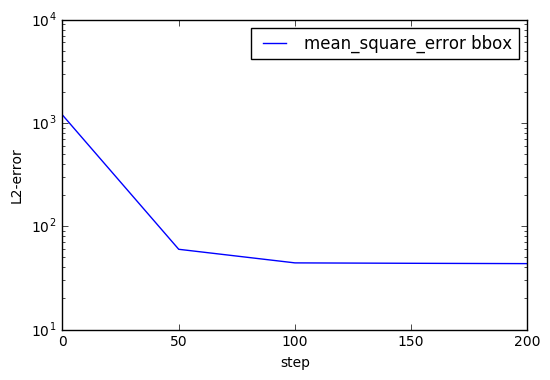

In [9]:
plt.yscale('log')
plt.show()

In [90]:
def predict_with_model(y, model_name):

    test_dataset = y
 
    #parameters
    batch_size = 20
    image_size = 64
    patch_size = 3

    d1 = 4
    d2 = 8
    d3 = 16
    d4 = 32
    d5 = 64
    d6 = 128
    d7 = 256
    d8 = 512
    sdev = math.sqrt(2.0 / (32**2*1))


    #tensorflow computational graph
    graph = tf.Graph()
    with graph.as_default():

        # Input data.
        tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size, image_size, 1))
        tf_train_bbox = tf.placeholder(tf.float32, shape=(batch_size,4))
        tf_eval = tf.placeholder(tf.float32,shape=(batch_size, image_size, image_size, 1))

        
        # Variables.
        conv1_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, 1, d1], stddev=sdev))
        conv1_b = tf.Variable(tf.zeros([d1]))
        
        conv2_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d1, d2], stddev=sdev))
        conv2_b = tf.Variable(tf.zeros([d2]))
        
        conv3_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d2, d3], stddev=sdev))
        conv3_b = tf.Variable(tf.zeros([d3]))
        
        conv4_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d3, d4], stddev=sdev))
        conv4_b = tf.Variable(tf.zeros([d4]))
        
        conv5_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d4, d5], stddev=sdev))
        conv5_b = tf.Variable(tf.zeros([d5]))
        
        conv6_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d5, d6], stddev=sdev))
        conv6_b = tf.Variable(tf.zeros([d6]))
        
        conv7_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d6, d7], stddev=sdev))
        conv7_b = tf.Variable(tf.zeros([d7]))
        
        conv8_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d7, d8], stddev=sdev))
        conv8_b = tf.Variable(tf.zeros([d8]))
        
        fc1_w = tf.Variable(tf.truncated_normal([128,512], stddev=0.1))
        fc1_b = tf.Variable(tf.constant(1.0, shape=[64]))

        #for final logits
        hidden2 = 512
        b1_w = tf.get_variable('b1_w', shape=[hidden2, 1],initializer=tf.contrib.layers.xavier_initializer())
        b1_b = tf.Variable(tf.constant(1.0, shape=[1]))
        b2_w = tf.get_variable('b2_w',shape=[hidden2, 1],initializer=tf.contrib.layers.xavier_initializer())
        b2_b = tf.Variable(tf.constant(1.0, shape=[1]))
        b3_w = tf.get_variable('b3_w',shape=[hidden2, 1],initializer=tf.contrib.layers.xavier_initializer())
        b3_b = tf.Variable(tf.constant(1.0, shape=[1]))
        b4_w = tf.get_variable('b4_w',shape=[hidden2, 1],initializer=tf.contrib.layers.xavier_initializer())
        b4_b = tf.Variable(tf.constant(1.0, shape=[1]))

        # Model.
        def model(data):
            '''
            Our best architecture consists of eight convolutional hidden layers
            one locally connected hidden layer, and two densely connected hidden layers.
            All connections are feedforward and go from one layer to the next (no skip connections).
            The first hidden layer contains maxout units (Goodfellow et al., 2013) (with three filters per unit)
            while the others contain rectifier units (Jarrett et al., 2009; Glorot et al., 2011). 
            The number of units at each spatial location in each layer is [48, 64, 128, 160] 
            for the first four layers and 192 for all other locally connected layers. 
            The fully connected layers contain 3,072 units each. 
            Each convolutional layer includes max pooling and subtractive normalization. 
            The max pooling window size is 2 × 2. 
            The stride alternates between 2 and 1 at each layer, 
            so that half of the layers don’t reduce the spatial size of the representation. 
            All convolutions use zero padding on the input to preserve representation size. 
            The subtractive normalization operates on 3x3 windows and preserves representation size. 
            All convolution kernels were of size 5 × 5. 
            We trained with dropout applied to all hidden layers but not the input.
            '''
            pad  = 'SAME'
            conv1 = tf.nn.conv2d(data, conv1_w, [1, 1, 1, 1], padding=pad)
            conv1 = tf.nn.relu(conv1 + conv1_b)
            conv1 = tf.nn.max_pool(conv1, [1,2,2,1], [1,2,2,1], padding=pad)
    #         print(conv1.get_shape())
            conv2 = tf.nn.conv2d(conv1, conv2_w, [1, 1, 1, 1], padding=pad)
            conv2 = tf.nn.relu(conv2 + conv2_b)
            conv2 = tf.nn.max_pool(conv2, [1,2,2,1], [1,2,2,1], padding=pad)
    #         print(conv2.get_shape())
            conv3 = tf.nn.conv2d(conv2, conv3_w, [1, 1, 1, 1], padding=pad)
            conv3 = tf.nn.relu(conv3 + conv3_b)
            conv3 = tf.nn.max_pool(conv3, [1,2,2,1], [1,2,2,1], padding=pad)
    #         print(conv3.get_shape())
            conv4 = tf.nn.conv2d(conv3, conv4_w, [1, 1, 1, 1], padding=pad)
            conv4 = tf.nn.relu(conv4 + conv4_b)
            conv4 = tf.nn.max_pool(conv4, [1,2,2,1], [1,2,2,1], padding=pad)
    #         print(conv4.get_shape())
            conv5 = tf.nn.conv2d(conv4, conv5_w, [1, 1, 1, 1], padding=pad)
            conv5 = tf.nn.relu(conv5 + conv5_b)
            conv5 = tf.nn.max_pool(conv5, [1,2,2,1], [1,2,2,1], padding=pad)
    #         print(conv5.get_shape())
            conv6 = tf.nn.conv2d(conv5, conv6_w, [1, 1, 1, 1], padding=pad)
            conv6 = tf.nn.relu(conv6 + conv6_b)
            conv6 = tf.nn.max_pool(conv6, [1,2,2,1], [1,2,2,1], padding=pad)
    #         print(conv6.get_shape())
            conv7 = tf.nn.conv2d(conv6, conv7_w, [1, 1, 1, 1], padding=pad)
            conv7 = tf.nn.relu(conv7 + conv7_b)
            conv7 = tf.nn.max_pool(conv7, [1,2,2,1], [1,2,2,1], padding=pad)
    #         print(conv7.get_shape())
            conv8 = tf.nn.conv2d(conv7, conv8_w, [1, 1, 1, 1], padding=pad)
            conv8 = tf.nn.relu(conv8 + conv8_b)
            conv8 = tf.nn.max_pool(conv8, [1,2,2,1], [1,2,2,1], padding=pad)
    #         print(conv8.get_shape())
        
            #bounding box
            shape_bb = conv8.get_shape().as_list()
            reshape_bb = tf.reshape(conv8, [shape_bb[0], shape_bb[1] * shape_bb[2] * shape_bb[3]])  
            fc1_bb = tf.nn.dropout(reshape_bb, keep_prob = 0.8)
            
            #four classifiers for the bounding box, locating the number in the image
            b1 = tf.matmul(fc1_bb, b1_w) + b1_b
            b2 = tf.matmul(fc1_bb, b2_w) + b2_b
            b3 = tf.matmul(fc1_bb, b3_w) + b3_b
            b4 = tf.matmul(fc1_bb, b4_w) + b4_b
            
            return [b1, b2, b3, b4]

        # Training computation. #no length logit
        [b1, b2, b3, b4] = model(tf_train_dataset)
        
        # Add ops to save and restore all the variables.
        saver = tf.train.Saver()

        #regression loss
        loss = tf.reduce_mean(tf.square(b1-tf_train_bbox[:,0])) +\
        tf.reduce_mean(tf.square(b2-tf_train_bbox[:,1])) +\
        tf.reduce_mean(tf.square(b3-tf_train_bbox[:,2])) +\
        tf.reduce_mean(tf.square(b4-tf_train_bbox[:,3]))
        
        # Optimizer.
        optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss) 
        
        # Predictions for the training and evaluation data
        train_prediction = tf.pack([b1, b2, b3, b4])
        
        eval_prediction = tf.pack([model(tf_eval)[0], model(tf_eval)[1], model(tf_eval)[2], model(tf_eval)[3]])

        test_prediction = tf.pack(model(test_dataset))
        
    with tf.Session(graph=graph) as sess:

        sess.run(tf.initialize_all_variables())
        saver.restore(sess, os.getcwd() + model_name)
        pred = test_prediction.eval()
        pred = [list(i) for i in zip(*[i.flatten() for i in pred])]

        return pred

def format_image(path, image_name):
    image_size = 64
    filename = path + '/' + image_name
    img = Image.open(filename)
    img = img.filter(ImageFilter.GaussianBlur(radius=5))
    img = misc.fromimage(img, flatten = True)
    img = np.array(img)
    img = misc.imresize(img, (image_size,image_size))
    #normalize
    img = img/float(img.max())*1. - (1./2.) #centering image around 0
    img = img.reshape((-1, image_size, image_size, 1)).astype(np.float32)
    
    return img

def image(path, image_name):
    filename = path + '/' + image_name
    img = Image.open(filename)
    img = misc.fromimage(img, flatten = False)
    img = np.array(img)
    return img

# path = os.getcwd()
# file_names = ['image1.jpg', 'image2.jpg', 'image3.jpg', 'image4.jpg', 'image5.jpg','image7.png', 'image8.jpg']
# # file_names = ['image7.png']

def predict_show(file_name, model_name, show = True):

    path = os.getcwd()
    img = format_image(path, file_name)
    print(img.shape)
    img_big = image(path, file_name)
    label = predict_with_model(img, model_name)
    print(label[0])

    label = label[0]
    label = [20., 30., 40., 20.]
    # Create figure and axes
    fig,ax = plt.subplots(1)
    ax.imshow(img_big)
    # Create a Rectangle patch
    y_top = float(label[1])* float(img_big.shape[0]/64. )
    x_top = float(label[2])* float(img_big.shape[1]/64. )
    height = float(label[1]-label[0]) * img_big.shape[0]/64. 
    width = float(label[3]-label[2])  * img_big.shape[1]/64.
    rect = patches.Rectangle((x_top,y_top), width, -height, linewidth=3,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

    if show == True:
        plt.show()    


[10.657078, 52.52808, 23.599754, 39.521698]


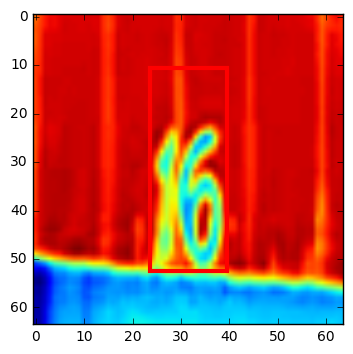

In [89]:
import matplotlib.patches as patches

path = os.getcwd()
model_name = '/STEP4_model_bbox.ckpt'
img = format_image(path, 'image3.png')
img = test_dataset[20:21,:,:,:]
img_big = img
label = predict_with_model(img, model_name)
label = label[0]
print(label)
# Create figure and axes
fig,ax = plt.subplots(1)
ax.imshow(img[0,:,:,0])
# Create a Rectangle patch
y_top = float(label[0])
x_top = float(label[2])
height = float(label[0]-label[1])
width = float(label[3]-label[2])
rect = patches.Rectangle((x_top,y_top), width, -height, linewidth=3,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

In [70]:
print(label)

[[10.612228, 44.850372, 21.224701, 33.983704]]


In [57]:
predict_with_model(img[:,:,:,:], model_name)

[[[ 142.69238281]]

 [[ 702.862854  ]]

 [[ 276.69604492]]

 [[ 516.9887085 ]]]


[[142.69238, 702.86285, 276.69604, 516.98871]]